<a href="https://colab.research.google.com/github/inokchoi/ComputerVision/blob/main/Finetuning_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/20-1computervision/Assignment2'

/content/drive/My Drive/Colab Notebooks/20-1computervision/Assignment2


In [ ]:
!pip install livelossplot # Beautiful liveloss plot for jupyter

In [ ]:
#!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, transforms
#from torchsummary import summary
from torch.utils.data import DataLoader

from IPython.display import clear_output
from livelossplot import PlotLosses 

import os

In [ ]:
transform = transforms.Compose([
    #transforms.Resize(227),
    transforms.Resize(32),    #Assignment2 수정 요청 사항
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
train_data = datasets.ImageFolder('./train/', transform)
test_data = datasets.ImageFolder('./test', transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
len(train_loader)

63

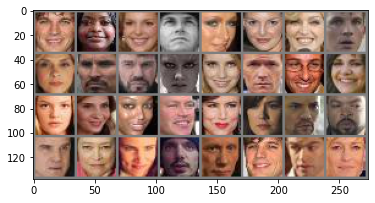

Matt_Lanter


In [ ]:
def imshow(img):
    img = img/2 + 0.5
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1,2,0)))
    plt.show()
 
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(train_data.classes[labels[0]])

In [ ]:
FINE_TUNE = True # True: 전체 네트워크 학습, False: 최종 마지막 network만 학습

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        '''
        self.conv1 = nn.Conv2d(3,96,11,4)
        self.conv2 = nn.Conv2d(96,256,5,padding=2,groups=2)
        self.conv3 = nn.Conv2d(256,384,3,padding=1, groups=2)
        self.conv4 = nn.Conv2d(384,384,3,padding=1, groups=2)
        self.conv5 = nn.Conv2d(384,256,3,padding=1, groups=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,num_classes)
        '''
        self.conv1 = nn.Conv2d(3,48,3)
        self.conv2 = nn.Conv2d(48,128,3,padding=2,groups=2)  #in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(128,256,3,padding=1, groups=2)
        self.conv4 = nn.Conv2d(256,256,3,padding=1, groups=2)
        self.conv5 = nn.Conv2d(256,128,3,padding=1, groups=2)
        self.fc1 = nn.Linear(128*4*4,1024)
        self.fc2 = nn.Linear(1024,1024)
        self.fc3 = nn.Linear(1024,num_classes)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(F.relu(self.conv5(x)),(2,2))
        x = x.view(x.size(0),128*4*4)
        x = F.dropout(F.relu(self.fc1(x)),p=0.5)
        x = F.dropout(F.relu(self.fc2(x)),p=0.5)
        x = self.fc3(x)
        return x

In [ ]:
#net = AlexNet()
#summary(net, input_size=(3, 32, 32))

In [ ]:
net = torch.load('./model2')
#device = torch.device("cuda")
#net.to(device)

In [ ]:
# 일단 모든 layers를 requires_grad=False 를 통해서 학습이 안되도록 막습니다.
if not FINE_TUNE:
    for parameter in net.parameters():
        parameter.requires_grad = False
 
# 새로운 fully-connected classifier layer 를 만들어줍니다. (requires_grad 는 True)
# in_features: 2048 -> in 으로 들어오는 feature의 갯수
n_features = net.fc3.in_features
net.fc3 = nn.Linear(n_features, 100).cuda() 

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)


In [ ]:
device = torch.device("cuda")

In [ ]:
dataloaders = {
    'train': train_loader,
    'test' : test_loader
}

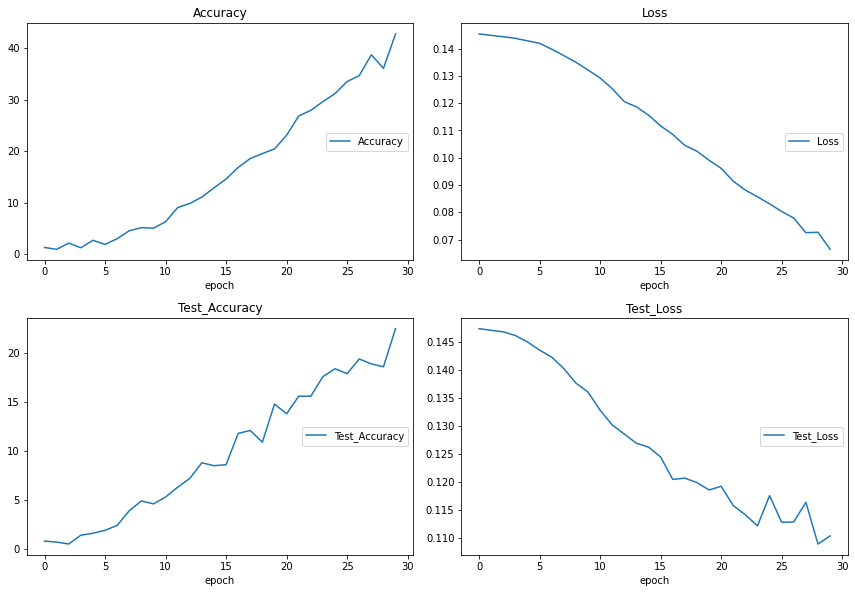

Accuracy
	Accuracy         	 (min:    0.950, max:   42.800, cur:   42.800)
Loss
	Loss             	 (min:    0.066, max:    0.145, cur:    0.066)
Test_Accuracy
	Test_Accuracy    	 (min:    0.500, max:   22.500, cur:   22.500)
Test_Loss
	Test_Loss        	 (min:    0.109, max:    0.147, cur:    0.110)
Finished Training


In [ ]:
liveloss = PlotLosses()

for epoch in range(30):

    logs = {}

    for phase in ['train', 'test']:
        if phase == 'train':
            net.train()
        else:
            net.eval()

        total_count = 0.0
        correct_count = 0.0
        running_loss = 0.0
        prefix = ''
        for i, data in enumerate(dataloaders[phase], 0):
            inputs, lables = data
            inputs = inputs.to(device)
            lables = lables.to(device)

            if phase == 'train':
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, lables)
                loss.backward()
                optimizer.step()
                prefix = ''
            else:
                with torch.no_grad():
                    outputs = net(inputs)
                    loss = criterion(outputs, lables)
                    prefix = 'Test_'
 
            running_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_count += lables.size(0)
            correct_count += predicted.eq(lables.data).sum().item()

            
        logs[prefix+'Loss'] = running_loss / total_count
        accuracy = 100 * correct_count / total_count
        print('Total count:{}, Correct_count:{}, Loss:{}'.format(total_count, correct_count, running_loss))
        logs[prefix+'Accuracy'] = accuracy
    
    liveloss.update(logs)
    liveloss.draw()
 
print('Finished Training')
#torch.save(net, './model2')